# **Progetto Industy Lab**: *Data Exploration & Preparation*

#1) Data Exploration

In questo paragrafo si prende confidenza con i dati cercando di capire al meglio possibili andamenti anomali/errati all'interno di essi.

##Set Up

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import scipy
from datetime import datetime, date 
from scipy.stats import boxcox
# from termcolor import colored
import re
import math
import missingno as mnso
from functools import partial

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
# matplotlib_axes_logger.setLevel('ERROR')

import tensorflow as tf
import keras
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.api import VAR

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, HypothesisTestWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', HypothesisTestWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


##Utils

In [4]:
# Funzione utili da mettere in utils.py
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller


def adf_test(col):
    result = adfuller(col)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    print(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}')


def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'

##Descrtive Analysis

In [5]:
df = pd.read_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Original/Bacino_idrico.csv')

In [6]:
inferenced_LA = df.iloc[-8:-1]
inferenced_PU = df.iloc[[-1]]
inferenced_LA.to_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Inference/infer_LA.csv')
inferenced_PU.to_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Inference/infer_PU.csv')

In [7]:
inferenced_LA

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
6378,23/06/2020,0.0,0.0,0.0,0.0,0.0,22.50,29.86,0.6
6379,24/06/2020,0.0,0.0,0.0,0.0,0.0,22.15,29.86,0.6
6380,25/06/2020,0.0,0.0,0.0,0.0,0.0,22.35,29.87,0.6
6381,26/06/2020,0.0,0.0,0.0,0.0,0.0,22.50,29.85,0.6
6382,27/06/2020,0.0,0.0,0.0,0.0,0.0,23.40,29.84,0.6
6383,28/06/2020,0.0,0.0,0.0,0.0,0.0,21.50,29.83,0.6
6384,29/06/2020,0.0,0.0,0.0,0.0,0.0,23.20,29.82,0.6


In [8]:
df=df.iloc[0:-1]

In [9]:
df.columns

Index(['Data', 'Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3',
       'Pioggia_Zona_4', 'Pioggia_Zona_5', 'Temperatura_Zona_5',
       'Livello_Acqua', 'Portata_Uscita'],
      dtype='object')

In [10]:
df.shape

(6385, 9)

In [11]:
print('Starting date is :' , df['Data'].iloc[0],
      '\nEnding Date is : ',df["Data"].iloc[-1])

Starting date is : 06/01/2003 
Ending Date is :  29/06/2020


In [12]:
pd.Series(df.isnull().sum()).rename_axis('features/target').to_frame('Missing Value Count')

,Missing Value Count
features/target,
Data,0
Pioggia_Zona_1,360
Pioggia_Zona_2,360
Pioggia_Zona_3,360
Pioggia_Zona_4,360
Pioggia_Zona_5,360
Temperatura_Zona_5,361
Livello_Acqua,0
Portata_Uscita,0


In [13]:
df.describe()

,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
count,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6024.000000,6385.000000,6385.000000
mean,2.471635,3.341212,2.670506,2.675187,3.130390,14.528777,28.571768,2.784962
std,6.650488,8.903769,7.167155,7.656404,8.025686,6.943797,2.196266,4.098661
min,0.000000,0.000000,0.000000,0.000000,0.000000,-5.350000,22.530000,0.450000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,26.930000,0.600000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,14.500000,29.260000,1.500000
75%,0.800000,1.400000,1.200000,0.600000,1.200000,20.100000,30.430000,3.000000
max,80.600000,110.000000,120.200000,113.600000,88.400000,34.000000,31.760000,74.650000


## Missinig Analysis

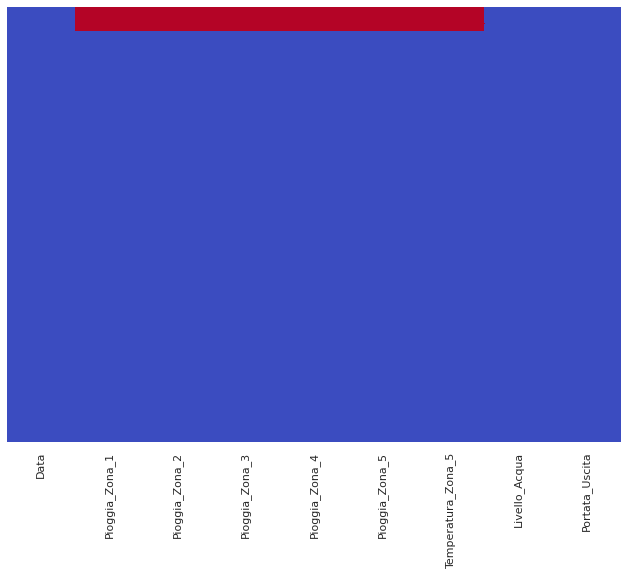

In [14]:
sns.set(rc={'figure.figsize':(11,8)})
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap="coolwarm")

# From this visualisation it is clear the missing data is at top that is old data, so we can drop those.

In [15]:
df_clean = df.dropna(axis=0)
df_clean.isnull().sum().sum()

0

In [16]:
print('New starting date :' ,      
      df_clean['Data'].iloc[0],
      '\nNew ending Date:',      
      df_clean['Data'].iloc[-1])

New starting date : 02/01/2004 
New ending Date: 29/06/2020


## EDA

<Figure size 720x360 with 0 Axes>

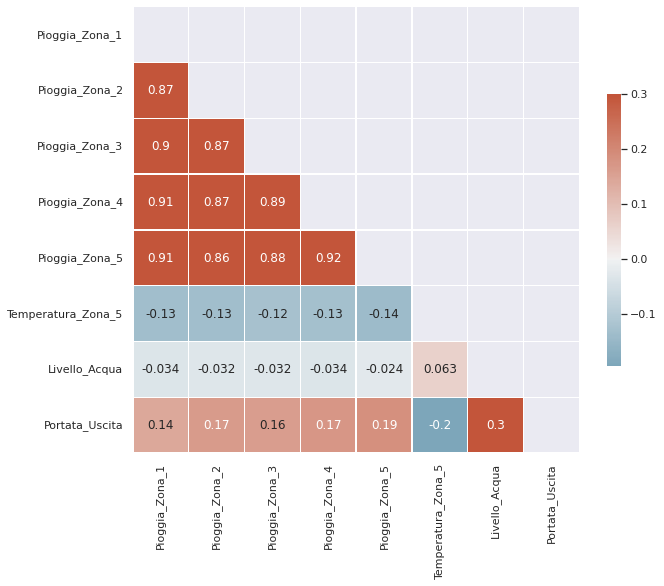

In [17]:
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), mask = mask, annot=True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

In [18]:
df['Data'] = pd.to_datetime(df['Data'], format = '%d/%m/%Y')
df = df.sort_values(by='Data')
df['Diff'] = df['Data'] - df['Data'].shift(1)
df['Diff'].value_counts()

1 days    6384
Name: Diff, dtype: int64

In [19]:
df = df.drop('Diff', axis=1)

In [20]:
df.columns

Index(['Data', 'Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3',
       'Pioggia_Zona_4', 'Pioggia_Zona_5', 'Temperatura_Zona_5',
       'Livello_Acqua', 'Portata_Uscita'],
      dtype='object')

In [21]:
feature_list = ['Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3',
       'Pioggia_Zona_4', 'Pioggia_Zona_5', 'Temperatura_Zona_5']

df.set_index('Data', inplace=True)

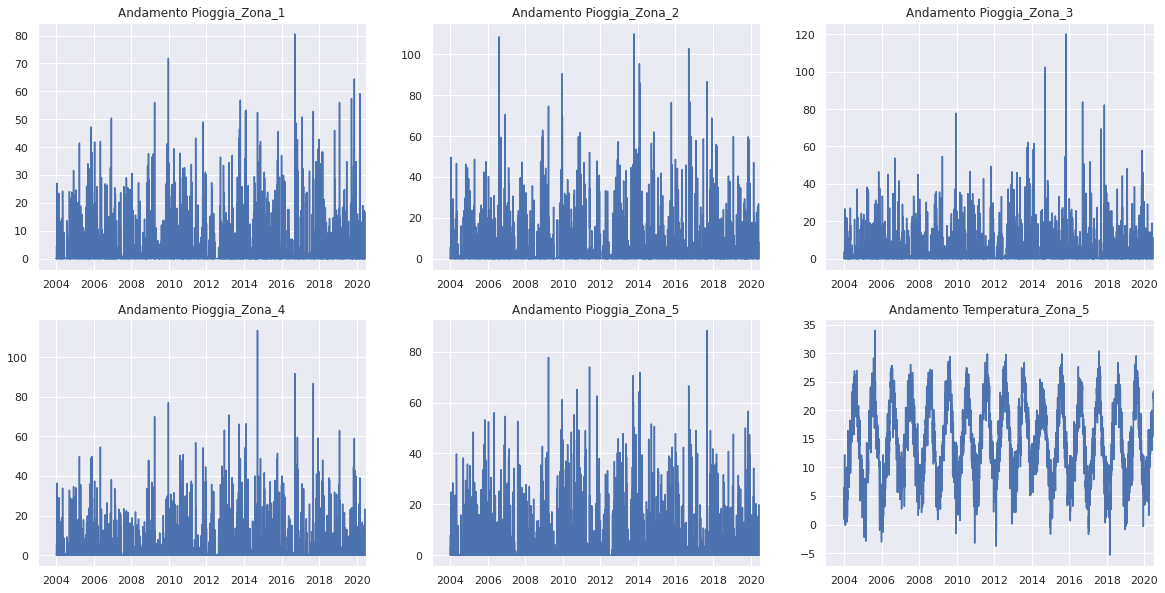

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=3)
count=0
for r in range(2):
    for c in range(3):
        ax = df[feature_list[count]].plot(ax=axes[r,c],figsize=(20, 10), title='Andamento '+feature_list[count])
        ax.set(xlabel='', ylabel='')
        count+=1

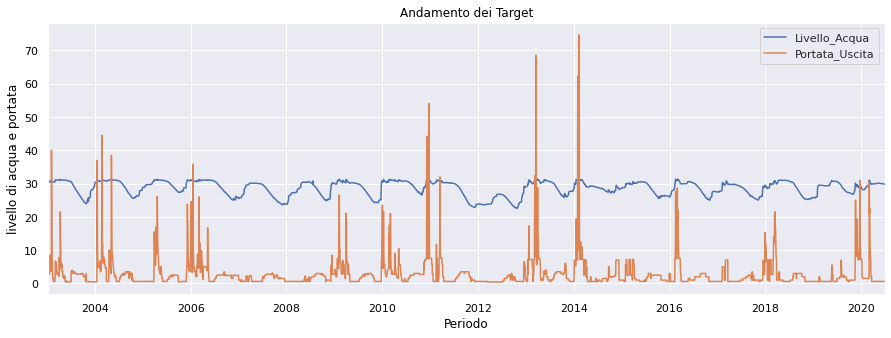

In [23]:
title='Andamento dei Target'
ylabel='livello di acqua e portata'
xlabel='Periodo'

ax = df[['Livello_Acqua', 'Portata_Uscita']].plot(figsize=(15, 5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.label.set_color('black')
ax.xaxis.label.set_color('black')
ax.title.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.yaxis.grid(True)
ax.xaxis.grid(True)
fig=ax.get_figure()


In [24]:
df

,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
Data,,,,,,,,
2003-01-06,NaN,NaN,NaN,NaN,NaN,NaN,30.70,9.6
2003-01-07,NaN,NaN,NaN,NaN,NaN,NaN,30.70,9.5
2003-01-08,NaN,NaN,NaN,NaN,NaN,NaN,30.67,9.5
2003-01-09,NaN,NaN,NaN,NaN,NaN,NaN,30.66,7.2
2003-01-10,NaN,NaN,NaN,NaN,NaN,NaN,30.64,6.2
...,...,...,...,...,...,...,...,...
2020-06-25,0.0,0.0,0.0,0.0,0.0,22.35,29.87,0.6
2020-06-26,0.0,0.0,0.0,0.0,0.0,22.50,29.85,0.6
2020-06-27,0.0,0.0,0.0,0.0,0.0,23.40,29.84,0.6


In [25]:
dfcopy=df.reset_index()
dfcopy['Data'] = pd.to_datetime(dfcopy['Data'], format="%d/%m/%Y")
dfcopy['season'] = dfcopy.Data.map(season_of_date)
dfcopy['weekday'] = dfcopy['Data'].dt.dayofweek

In [26]:
dfcopy['Month'] = dfcopy['Data'].dt.month

In [27]:
dfcopy['Year'] = dfcopy['Data'].dt.year

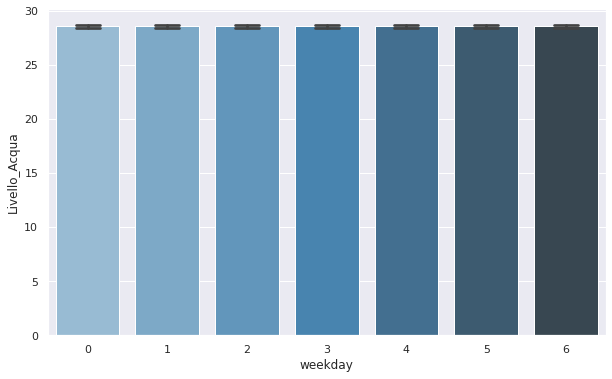

In [28]:
fig = plt.figure(figsize=(10,6))
sns.barplot(x='weekday', y='Livello_Acqua', data=dfcopy, capsize=.3 ,palette="Blues_d")
plt.show()

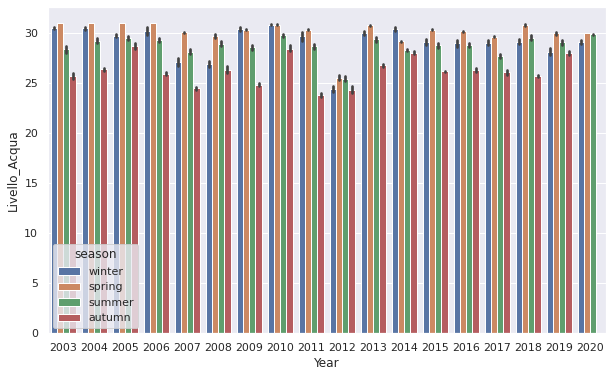

In [29]:
fig = plt.figure(figsize=(10,6))
sns.barplot(x='Year', y='Livello_Acqua', hue="season", data=dfcopy)
plt.show()

#2) Preprocessing Target 1: **Livello Acqua**.

L'obbiettivo di questa sezione è preparare i dati al meglio per poter inferire  il "*Livello_Acqua*", primo target del task. 

###2.1) Sarimax Preprocessing

Per poter processare i dati da dare in pasto al modello sarimax, seleziono la variabile target, unica variabile utile allo scopo.

In [ ]:
sar_data = pd.DataFrame(df['Livello_Acqua']).iloc[:len(df)-7,]
print(sar_data.shape)


(6378, 1)


Come visto già dall'esplorazione la serie risulta stazionaria, il test di Dickey Fuller lo conferma

In [ ]:
adf_test(sar_data['Livello_Acqua'])

ADF Statistic -6.076, p-value: 0.000


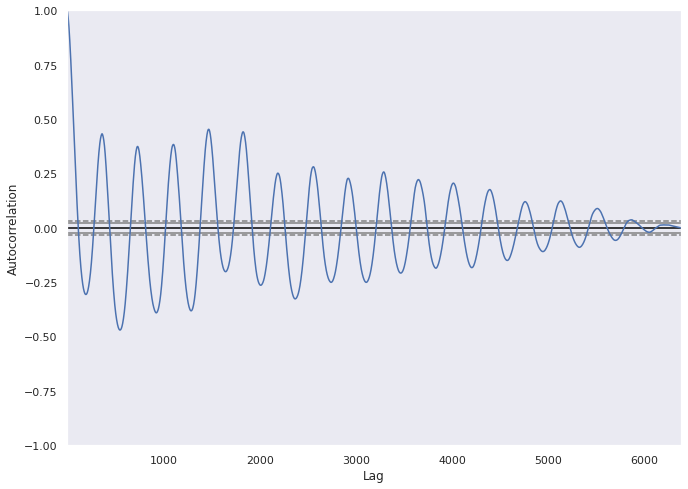

In [ ]:
autocorrelation_plot(sar_data);

L'autocorrellazione sparisce al lag 5500 circa

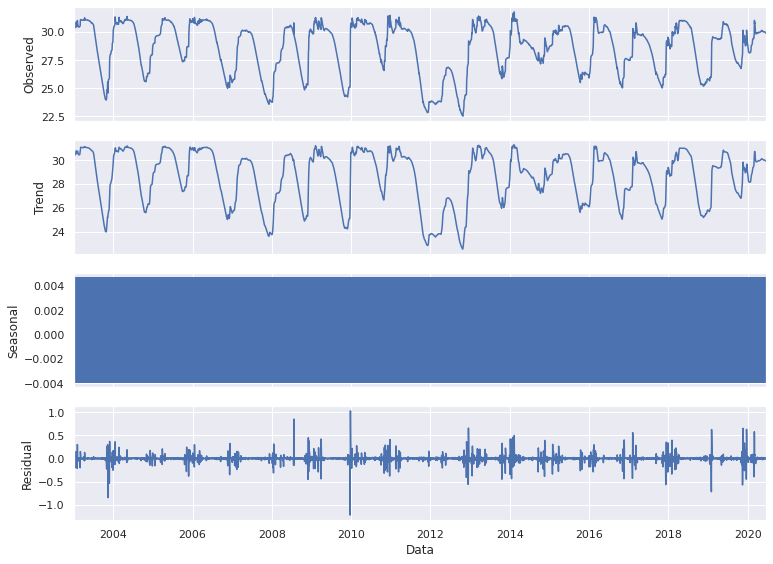

In [ ]:
result=seasonal_decompose(sar_data, model='additive')
result.plot()
plt.show()

Eviednza di una forte stagionalità

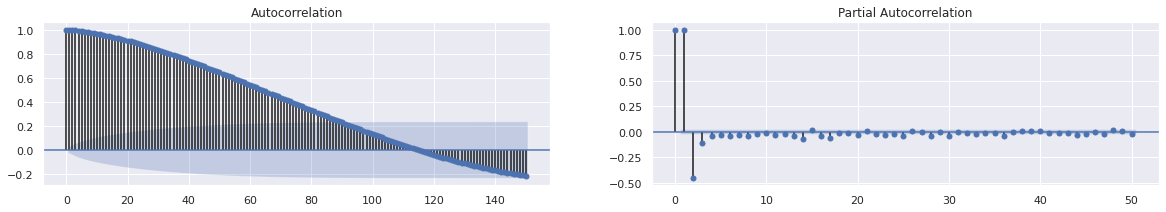

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 3))
plot_acf(sar_data['Livello_Acqua'],lags=150, ax=ax1)
plot_pacf(sar_data['Livello_Acqua'],lags=50, ax=ax2)
plt.show()

L'ACF ha una correlazione significativamente alta nei lag iniziali (circa fino all'85 lag). Il PACF ha invece una correlazione positiva alta nei primi 2 lag e negativa nel 3 e poi resta negativa nella maggiorparte dei lag.

In [ ]:
train = sar_data.iloc[:int(sar_data.shape[0]-365)]
test = sar_data.iloc[int(sar_data.shape[0]-365):]


In [ ]:
train.tail(1)

,Livello_Acqua
Data,
2019-06-23,30.66


In [ ]:
test.head(1)

,Livello_Acqua
Data,
2019-06-24,30.67


In [ ]:
train.to_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/train_sarima.csv')
test.to_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/test_sarima.csv')

###2.3) Supervised Learning Preprocessing 

In [ ]:
df_xg = df_clean 
df_xg.shape

(6024, 9)

In [ ]:
df_xg['Data'] = pd.to_datetime(df_xg['Data'], format="%d/%m/%Y")
df_xg['season'] = df_xg.Data.map(season_of_date)

In [ ]:
seas = pd.get_dummies(df_xg['season'])
df_xg = pd.concat([df_xg,seas], axis=1)
df_xg.drop('season', axis=1, inplace=True)
df_xg['month'] = df_xg['Data'].dt.month
df_xg['year'] = df_xg['Data'].dt.year
df_xg['Pioggia_mediana'] = df_xg[['Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3',
       'Pioggia_Zona_4', 'Pioggia_Zona_5']].median(axis = 1)
df_xg['Pioggia_std'] = df_xg[['Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3',
       'Pioggia_Zona_4', 'Pioggia_Zona_5']].std(axis = 1)
df_xg.head(14)

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita,autumn,spring,summer,winter,month,year,Pioggia_mediana,Pioggia_std
361,2004-01-02,0.0,0.0,0.0,0.0,0.0,6.50,30.21,0.5,0,0,0,1,1,2004,0.0,0.000000
362,2004-01-03,0.0,0.0,0.0,0.0,0.0,4.45,30.28,0.5,0,0,0,1,1,2004,0.0,0.000000
363,2004-01-04,0.0,0.0,0.0,0.0,0.0,2.00,30.35,0.5,0,0,0,1,1,2004,0.0,0.000000
364,2004-01-05,0.2,0.0,0.0,0.0,0.0,0.90,30.37,0.5,0,0,0,1,1,2004,0.0,0.089443
365,2004-01-06,0.0,0.0,0.0,0.0,0.0,2.25,30.42,0.5,0,0,0,1,1,2004,0.0,0.000000
366,2004-01-07,0.0,0.0,0.0,0.0,0.0,3.65,30.43,0.5,0,0,0,1,1,2004,0.0,0.000000
367,2004-01-08,0.0,0.8,0.0,0.0,0.0,3.35,30.45,0.5,0,0,0,1,1,2004,0.0,0.357771
368,2004-01-09,4.6,5.8,3.8,5.6,7.8,5.55,30.49,0.5,0,0,0,1,1,2004,5.6,1.507315
369,2004-01-10,0.0,0.0,0.0,0.0,0.0,6.10,30.52,0.5,0,0,0,1,1,2004,0.0,0.000000
370,2004-01-11,0.0,0.0,0.0,0.0,0.0,6.25,30.53,0.5,0,0,0,1,1,2004,0.0,0.000000


In [ ]:
for i in range(0,7):
  df_xg['Livello_Acqua_lag'+str(i)]=df_xg['Livello_Acqua'].shift(+i)

df_xg['Target']=df_xg['Livello_Acqua'].shift(-7)
df_xg.drop('Livello_Acqua', axis=1, inplace=True)
df_xg.dropna(axis=0, inplace=True)
df_xg.head()

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Portata_Uscita,autumn,spring,...,Pioggia_mediana,Pioggia_std,Livello_Acqua_lag0,Livello_Acqua_lag1,Livello_Acqua_lag2,Livello_Acqua_lag3,Livello_Acqua_lag4,Livello_Acqua_lag5,Livello_Acqua_lag6,Target
367,2004-01-08,0.0,0.8,0.0,0.0,0.0,3.35,0.5,0,0,...,0.0,0.357771,30.45,30.43,30.42,30.37,30.35,30.28,30.21,30.64
368,2004-01-09,4.6,5.8,3.8,5.6,7.8,5.55,0.5,0,0,...,5.6,1.507315,30.49,30.45,30.43,30.42,30.37,30.35,30.28,30.70
369,2004-01-10,0.0,0.0,0.0,0.0,0.0,6.10,0.5,0,0,...,0.0,0.000000,30.52,30.49,30.45,30.43,30.42,30.37,30.35,30.80
370,2004-01-11,0.0,0.0,0.0,0.0,0.0,6.25,0.5,0,0,...,0.0,0.000000,30.53,30.52,30.49,30.45,30.43,30.42,30.37,31.32
371,2004-01-12,1.8,1.6,1.2,3.4,3.6,6.70,0.5,0,0,...,1.8,1.100909,30.55,30.53,30.52,30.49,30.45,30.43,30.42,31.21


In [ ]:
df_xg.columns

Index(['Data', 'Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3',
       'Pioggia_Zona_4', 'Pioggia_Zona_5', 'Temperatura_Zona_5',
       'Portata_Uscita', 'autumn', 'spring', 'summer', 'winter', 'month',
       'year', 'Pioggia_mediana', 'Pioggia_std', 'Livello_Acqua_lag0',
       'Livello_Acqua_lag1', 'Livello_Acqua_lag2', 'Livello_Acqua_lag3',
       'Livello_Acqua_lag4', 'Livello_Acqua_lag5', 'Livello_Acqua_lag6',
       'Target'],
      dtype='object')

In [ ]:
df_xg['Livello_Acqua_mediana'] = df_xg[['Livello_Acqua_lag0','Livello_Acqua_lag1', 'Livello_Acqua_lag2', 'Livello_Acqua_lag3',
       'Livello_Acqua_lag4', 'Livello_Acqua_lag5', 'Livello_Acqua_lag6']].median(axis = 1)
df_xg['Livello_Acqua_std'] = df_xg[['Livello_Acqua_lag0','Livello_Acqua_lag1', 'Livello_Acqua_lag2', 'Livello_Acqua_lag3',
       'Livello_Acqua_lag4', 'Livello_Acqua_lag5', 'Livello_Acqua_lag6']].std(axis = 1)

In [ ]:
df_xg.describe()

,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Portata_Uscita,autumn,spring,summer,...,Livello_Acqua_lag0,Livello_Acqua_lag1,Livello_Acqua_lag2,Livello_Acqua_lag3,Livello_Acqua_lag4,Livello_Acqua_lag5,Livello_Acqua_lag6,Target,Livello_Acqua_mediana,Livello_Acqua_std
count,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,...,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000
mean,2.477358,3.348994,2.676659,2.681417,3.137681,14.530694,2.783377,0.236899,0.260190,0.250541,...,28.549972,28.550067,28.550156,28.550235,28.550306,28.550364,28.550414,28.549177,28.549278,0.093933
std,6.657170,8.912672,7.174360,7.664227,8.033604,6.936606,4.134592,0.425215,0.438774,0.433360,...,2.184634,2.184704,2.184769,2.184826,2.184878,2.184919,2.184954,2.184037,2.182335,0.133254
min,0.000000,0.000000,0.000000,0.000000,0.000000,-5.350000,0.450000,0.000000,0.000000,0.000000,...,22.530000,22.530000,22.530000,22.530000,22.530000,22.530000,22.530000,22.530000,22.570000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.600000,0.000000,0.000000,0.000000,...,26.920000,26.920000,26.920000,26.920000,26.920000,26.920000,26.920000,26.920000,26.915000,0.022678
50%,0.000000,0.000000,0.000000,0.000000,0.000000,14.500000,1.500000,0.000000,0.000000,0.000000,...,29.230000,29.230000,29.230000,29.230000,29.230000,29.230000,29.230000,29.230000,29.230000,0.063471
75%,0.800000,1.400000,1.200000,0.600000,1.200000,20.100000,3.000000,0.000000,1.000000,1.000000,...,30.375000,30.380000,30.380000,30.380000,30.380000,30.380000,30.380000,30.370000,30.380000,0.113631
max,80.600000,110.000000,120.200000,113.600000,88.400000,34.000000,74.650000,1.000000,1.000000,1.000000,...,31.760000,31.760000,31.760000,31.760000,31.760000,31.760000,31.760000,31.760000,31.210000,2.321916


<Figure size 720x360 with 0 Axes>

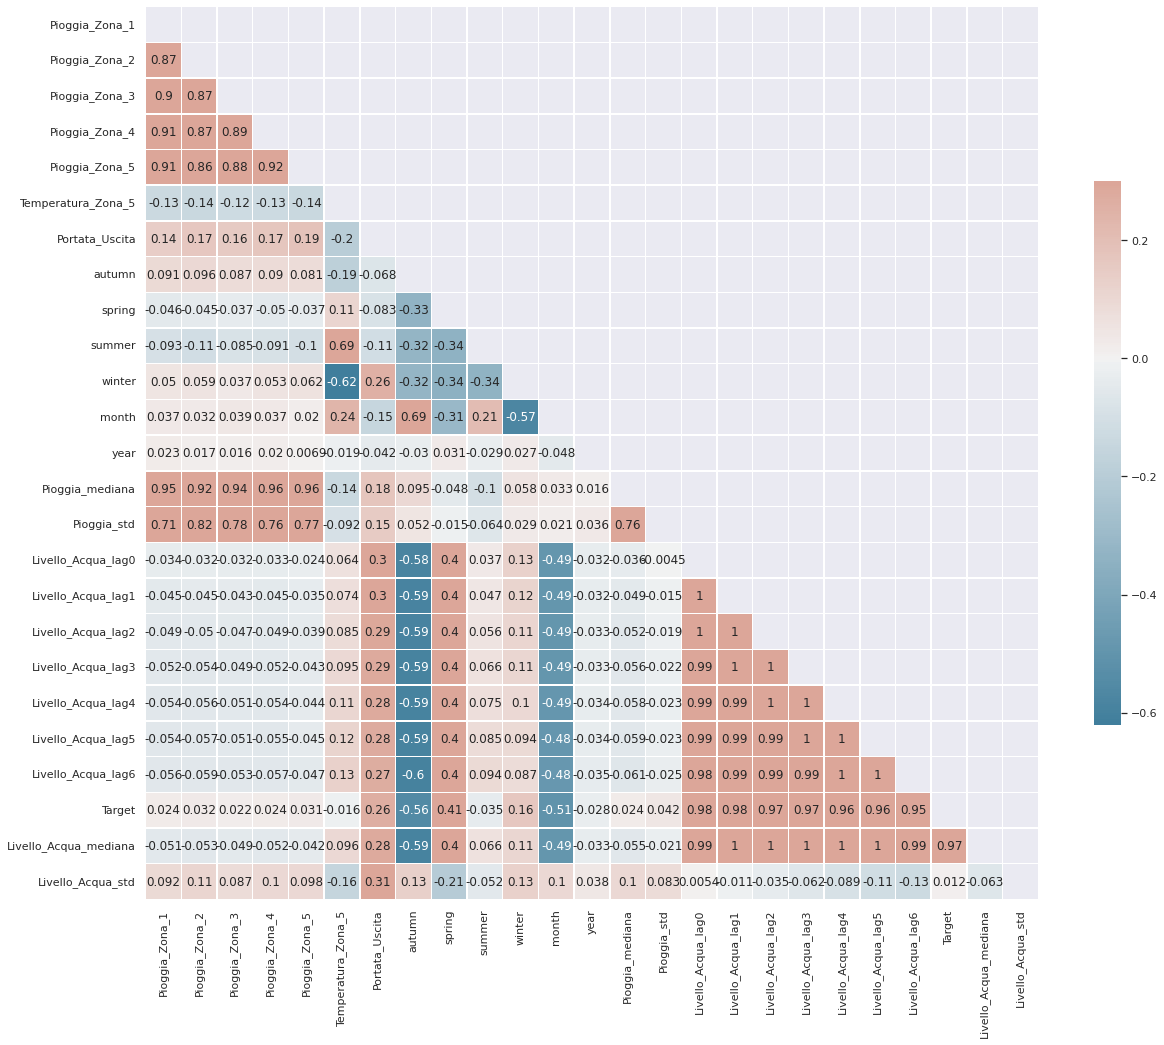

In [ ]:
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(df_xg.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df_xg.corr(), mask = mask, annot=True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

In [ ]:
Train = df_xg.iloc[:int(df_xg.shape[0]-365)]
Test = df_xg.iloc[int(df_xg.shape[0]-365):]

In [ ]:
Train.tail(1)

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Portata_Uscita,autumn,spring,...,Livello_Acqua_lag0,Livello_Acqua_lag1,Livello_Acqua_lag2,Livello_Acqua_lag3,Livello_Acqua_lag4,Livello_Acqua_lag5,Livello_Acqua_lag6,Target,Livello_Acqua_mediana,Livello_Acqua_std
6012,2019-06-23,0.0,0.0,0.0,0.0,0.0,23.15,0.6,0,0,...,30.66,30.6,30.63,30.63,30.63,30.64,30.66,30.6,30.63,0.020702


In [ ]:
Test.tail(1)

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Portata_Uscita,autumn,spring,...,Livello_Acqua_lag0,Livello_Acqua_lag1,Livello_Acqua_lag2,Livello_Acqua_lag3,Livello_Acqua_lag4,Livello_Acqua_lag5,Livello_Acqua_lag6,Target,Livello_Acqua_mediana,Livello_Acqua_std
6377,2020-06-22,0.0,0.0,0.0,0.0,0.0,23.05,0.6,0,0,...,29.86,29.88,29.9,29.92,29.93,29.91,29.92,29.82,29.91,0.024976


In [ ]:
Train.to_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/train_SL.csv')
Test.to_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/test_SL.csv')

#3) Preprocessing Target 2: **Portata Acqua**.

Per il secondo target, *Portata_Uscita*, si è deciso di processare i dati in un modo differente.


###3.1) Sarimax Preprocessing

Si seleziona la variabile target, unica variabile utile allo scopo (modello univariaro).

In [30]:
df_PU_SA = pd.DataFrame(df['Portata_Uscita']).iloc[:len(df)-7,]
print(df_PU_SA.shape)

(6378, 1)


Il test di Dickey Fuller conferma la stazionarietà della serie.

In [31]:
adf_test(df_PU_SA['Portata_Uscita'])

ADF Statistic -10.444, p-value: 0.000


L'autocorrelazione indica un dipendenza debole della variabile con la stessa variabile ritardata di t. 

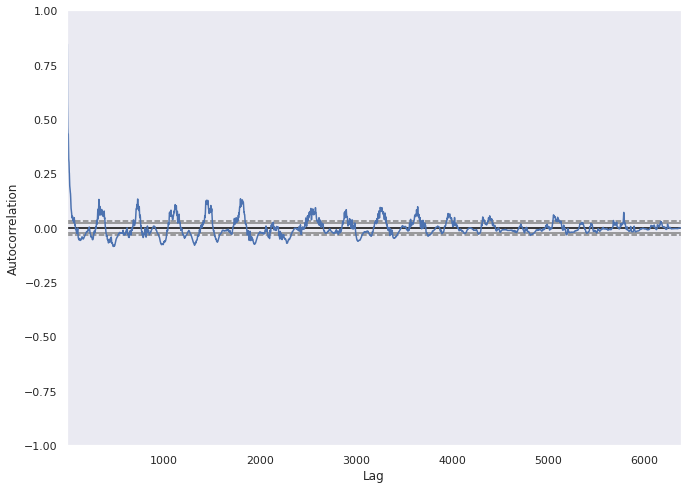

In [32]:
autocorrelation_plot(df_PU_SA);

Anche per questo target incide molto la componente stagionale.

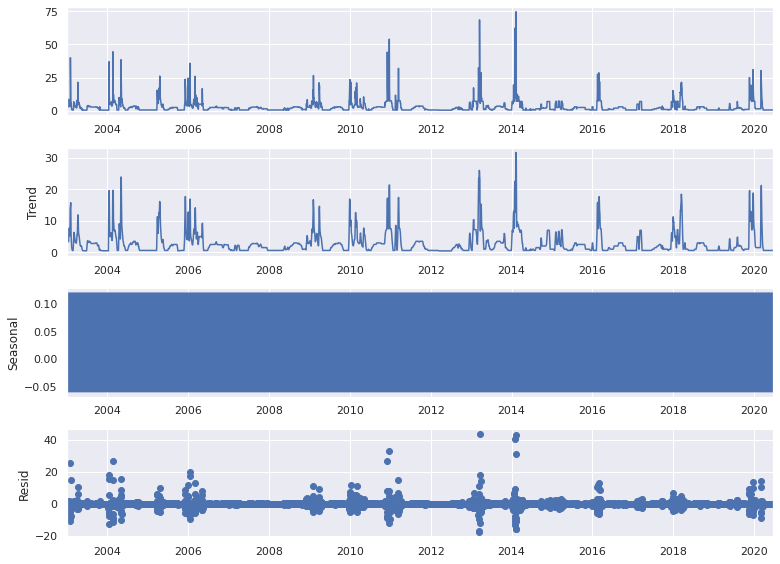

In [ ]:
result = seasonal_decompose(df_PU_SA, model='additive')
result.plot()
plt.show()

Anche per questo target l'ACF ha una correlazione significativamente alta nei lag iniziali (circa fino al 40 lag). Il PACF ha invece una correlazione positiva alta nei primi 2 lag e negativa nel 3.

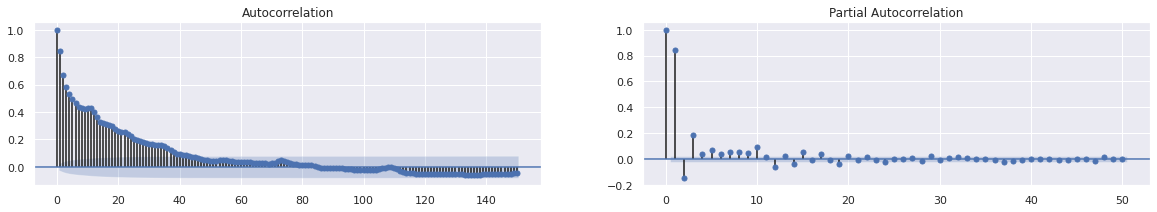

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 3))
plot_acf(df_PU_SA['Portata_Uscita'],lags=150, ax=ax1)
plot_pacf(df_PU_SA['Portata_Uscita'],lags=50, ax=ax2)
plt.show()

In [ ]:
train_PU_SA = df_PU_SA.iloc[:int(df_PU_SA.shape[0]-365)]
test_PU_SA = df_PU_SA.iloc[int(df_PU_SA.shape[0]-365):]

In [ ]:
train_PU_SA.to_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/train_PU_SA.csv')
test_PU_SA.to_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/test_PU_SA.csv')

## 3.2) Supervised Learning Preprocessing (Tentativo 1)

Si utilizza per il preprocessing il dataset pulito nella fase di missing analysis.

In [ ]:
df_PU_SL = df_clean.copy()
df_PU_SL.shape

(6024, 9)

Si aggiungono informazioni di tipo temporale:
- season (4 variabili dummy);
- year;
- month;
- day;
- week.


In [ ]:
df_PU_SL['Data'] = pd.to_datetime(df_PU_SL['Data'], format="%d/%m/%Y")
df_PU_SL['season'] = df_PU_SL.Data.map(season_of_date)

In [ ]:
seas = pd.get_dummies(df_PU_SL['season'])
df_PU_SL = pd.concat([df_PU_SL,seas], axis=1)
df_PU_SL.drop('season', axis=1, inplace=True)

In [ ]:
df_PU_SL['year'] = df_PU_SL.Data.dt.year
df_PU_SL['month'] = df_PU_SL.Data.dt.month
df_PU_SL['day_in_year'] = df_PU_SL.Data.dt.dayofyear
df_PU_SL['week_in_year'] = df_PU_SL.Data.dt.isocalendar().week.astype(int)

Si analizza la singola variabile temperatura utile per la predizione.

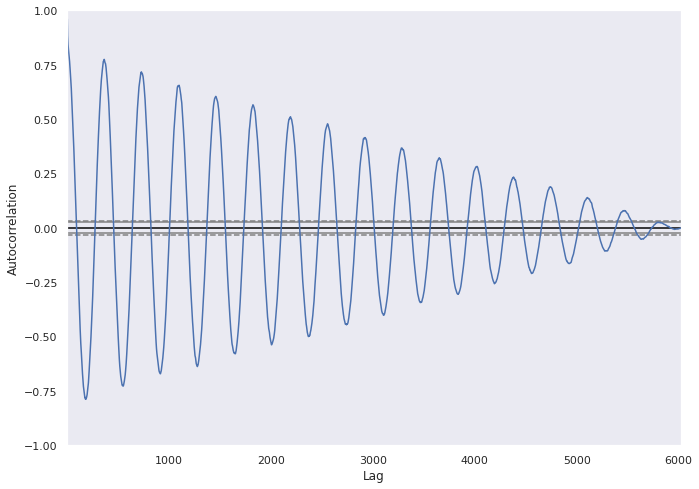

In [ ]:
pd.plotting.autocorrelation_plot(df_PU_SL.Temperatura_Zona_5)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


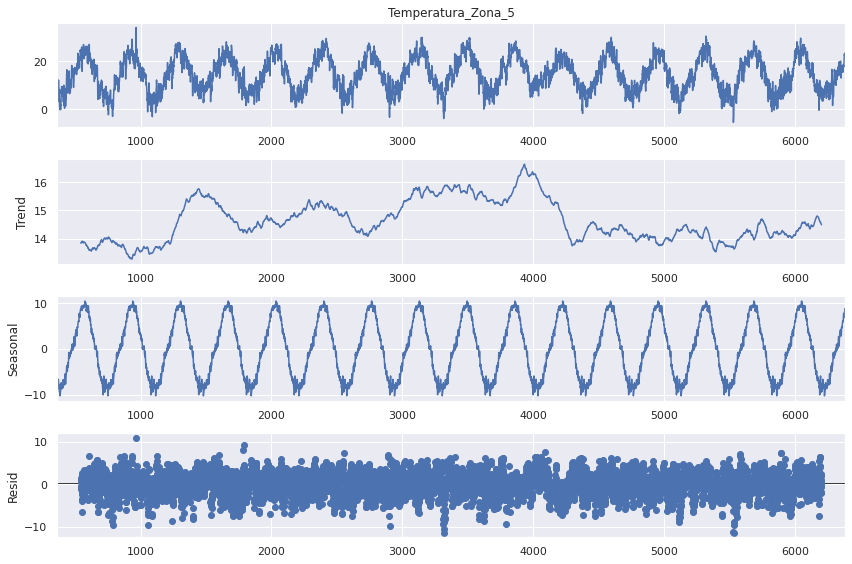

In [ ]:
decompose_result = seasonal_decompose(df_PU_SL.Temperatura_Zona_5, freq=365) 
plt.rcParams['figure.figsize'] = (12, 8) 
fig = decompose_result.plot()

Si scompone l'unica variabile di temperatura in 3 componenti:
- trend-ciclo;
- stagionale;
- irregolare.

Queste vengono successivamente aggiunte al dataset.

In [ ]:
df_PU_SL['Temperatura_Trend'] = decompose_result.trend
df_PU_SL['Temperatura_Season'] = decompose_result.seasonal
df_PU_SL['Temperatura_Resid'] = decompose_result.resid

In seguito si creano altre variabili che calcolano la differenza tra il valore corrente e il corrispettivo del giorno t-i con i da 1 a 6. Questo calcolo viene fatto per le variabili di pioggia e target.

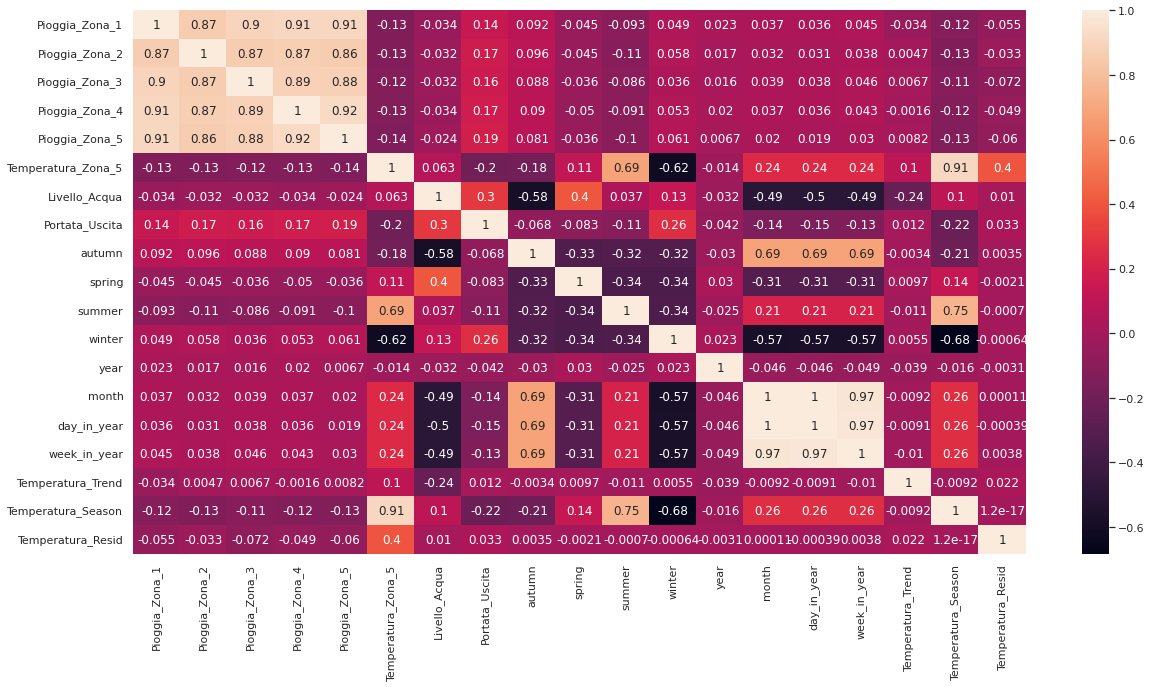

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_PU_SL.corr(), annot = True)

In [ ]:
for i in range(1, 7):
    df_PU_SL[f'Pioggia_Zona_1_diff_{i}'] = df_PU_SL['Pioggia_Zona_1'].diff(periods = i)
    df_PU_SL[f'Pioggia_Zona_2_diff_{i}'] = df_PU_SL['Pioggia_Zona_2'].diff(periods = i)
    df_PU_SL[f'Pioggia_Zona_3_diff_{i}'] = df_PU_SL['Pioggia_Zona_3'].diff(periods = i)
    df_PU_SL[f'Pioggia_Zona_4_diff_{i}'] = df_PU_SL['Pioggia_Zona_4'].diff(periods = i)
    df_PU_SL[f'Pioggia_Zona_5_diff_{i}'] = df_PU_SL['Pioggia_Zona_5'].diff(periods = i)
    df_PU_SL[f'Livello_Acqua_diff_{i}'] = df_PU_SL['Livello_Acqua'].diff(periods = i)
    df_PU_SL[f'Portata_Uscita_diff_{i}'] = df_PU_SL['Portata_Uscita'].diff(periods = i)

Vngono aggiunte le varibili shiftate:
- Temperatura_Trend shift 1;
- Temperatura_Season shift 1;
- Temperatura_Resid shift 1;
- Livello_Acqua shift 30;
- Portata_Uscita shift 30.

In [ ]:
df_PU_SL[['Temperatura_Trend_shifted','Temperatura_Season_shifted','Temperatura_Resid_shifted']] = df_PU_SL[['Temperatura_Trend','Temperatura_Season',
                                                                                                           'Temperatura_Resid']].shift(1)

df_PU_SL[['Livello_Acqua_shifted', 'Portata_Uscita_shifted']] = df_PU_SL[['Livello_Acqua', 'Portata_Uscita']].shift(30)

Infine si definisce la variabile Target, ossia la portata d'uscita tra 7 giorni.

In [ ]:
df_PU_SL['Target']=df_PU_SL['Portata_Uscita'].shift(-7)
df_PU_SL.drop('Portata_Uscita', axis=1, inplace=True)
df_PU_SL.dropna(axis=0, inplace=True)

In [ ]:
df_PU_SL.head(5)

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,autumn,spring,...,Pioggia_Zona_4_diff_6,Pioggia_Zona_5_diff_6,Livello_Acqua_diff_6,Portata_Uscita_diff_6,Temperatura_Trend_shifted,Temperatura_Season_shifted,Temperatura_Resid_shifted,Livello_Acqua_shifted,Portata_Uscita_shifted,Target
544,2004-07-03,0.0,0.0,0.0,0.0,0.0,21.15,30.83,0,0,...,0.0,0.0,-0.06,0.0,13.853151,8.841953,0.804897,31.02,2.0,1.5
545,2004-07-04,0.0,0.0,0.0,0.0,0.0,21.65,30.81,0,0,...,0.0,0.0,-0.07,0.0,13.852329,8.507972,-1.210300,31.02,2.0,1.5
546,2004-07-05,0.0,0.0,0.0,0.0,0.0,21.95,30.80,0,0,...,0.0,0.0,-0.07,0.0,13.857397,8.576747,-0.784144,31.02,2.0,2.0
547,2004-07-06,0.0,0.0,0.0,0.0,0.0,23.00,30.78,0,0,...,0.0,0.0,-0.08,0.4,13.863973,8.485472,-0.399444,31.02,2.0,2.0
548,2004-07-07,0.0,0.0,0.0,0.0,0.0,24.65,30.75,0,0,...,0.0,0.0,-0.10,0.4,13.875342,8.662543,0.462114,31.02,2.3,2.0


In [ ]:
df_PU_SL.describe()

,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,autumn,spring,summer,...,Pioggia_Zona_4_diff_6,Pioggia_Zona_5_diff_6,Livello_Acqua_diff_6,Portata_Uscita_diff_6,Temperatura_Trend_shifted,Temperatura_Season_shifted,Temperatura_Resid_shifted,Livello_Acqua_shifted,Portata_Uscita_shifted,Target
count,5659.000000,5659.00000,5659.00000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,...,5659.000000,5.659000e+03,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000
mean,2.474854,3.36024,2.70023,2.676091,3.150345,14.715824,28.444838,0.251635,0.243859,0.263651,...,0.000035,7.219687e-18,-0.001670,0.010972,14.639509,0.069596,0.010112,28.454004,2.642583,2.705897
std,6.710728,9.00029,7.29105,7.734809,8.120869,6.971844,2.198890,0.433991,0.429447,0.440651,...,10.751719,1.124621e+01,0.404055,3.958555,0.713202,6.366633,2.750078,2.205595,3.867663,3.946079
min,0.000000,0.00000,0.00000,0.000000,0.000000,-5.350000,22.530000,0.000000,0.000000,0.000000,...,-113.600000,-8.620000e+01,-1.230000,-67.450000,13.294658,-10.251994,-11.371504,22.530000,0.450000,0.450000
25%,0.000000,0.00000,0.00000,0.000000,0.000000,9.200000,26.755000,0.000000,0.000000,0.000000,...,-0.200000,-4.000000e-01,-0.225000,0.000000,14.083356,-6.314313,-1.877265,26.755000,0.600000,0.600000
50%,0.000000,0.00000,0.00000,0.000000,0.000000,14.700000,29.060000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,-0.060000,0.000000,14.473288,0.101619,0.159520,29.070000,1.500000,1.500000
75%,0.800000,1.40000,1.20000,0.400000,1.200000,20.450000,30.290000,1.000000,0.000000,1.000000,...,0.200000,4.000000e-01,0.050000,0.000000,15.254178,6.136134,1.920699,30.310000,3.000000,3.000000
max,80.600000,110.00000,120.20000,113.600000,88.400000,34.000000,31.760000,1.000000,1.000000,1.000000,...,113.600000,8.840000e+01,5.500000,64.680000,16.625890,10.479033,10.995710,31.760000,74.650000,74.650000


Split dei dati in train e test (80-20).

In [ ]:
n = len(df_PU_SL)
f = 0.8
train_PU_SL = df_PU_SL[:int(n*f)]
test_PU_SL = df_PU_SL[int(n*f):]

In [ ]:
train_PU_SL.to_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/train_PU_SL_T1.csv')
test_PU_SL.to_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/test_PU_SL_T1.csv')

## 3.3) Supervised Learning Preprocessing (Tentativo 2)

Anche qui si utilizza per il preprocessing il dataset pulito nella fase di missing analysis.

In [ ]:
df_PU_SL = df_clean.copy()
df_PU_SL.shape

(6024, 9)

In [ ]:
df_PU_SL.columns

Index(['Data', 'Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3',
       'Pioggia_Zona_4', 'Pioggia_Zona_5', 'Temperatura_Zona_5',
       'Livello_Acqua', 'Portata_Uscita'],
      dtype='object')

In [ ]:
features = ['Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3', 'Pioggia_Zona_4','Pioggia_Zona_5', 'Temperatura_Zona_5']

In [ ]:
df_PU_SL['Data'] = pd.to_datetime(df_PU_SL['Data'], format="%d/%m/%Y")

Si aggiungono informazioni di tipo temporale:
- year;
- month;
- day;
- week;
- year_sin;
- year_cos.

Le ultime due variabili permettono di catture la natura ciclica dei valori temporali come i giorni della settimana, mesi e stagioni. 

In [ ]:
df_PU_SL['year'] = df_PU_SL.Data.dt.year
df_PU_SL['month'] = df_PU_SL.Data.dt.month
df_PU_SL['day_in_year'] = df_PU_SL.Data.dt.dayofyear
df_PU_SL['week_in_year'] = df_PU_SL.Data.dt.isocalendar().week.astype(int)
df_PU_SL['year_sin'] = np.sin(2*np.pi*df_PU_SL['day_in_year']/365.25)
df_PU_SL['year_cos'] = np.cos(2*np.pi*df_PU_SL['day_in_year']/365.25)

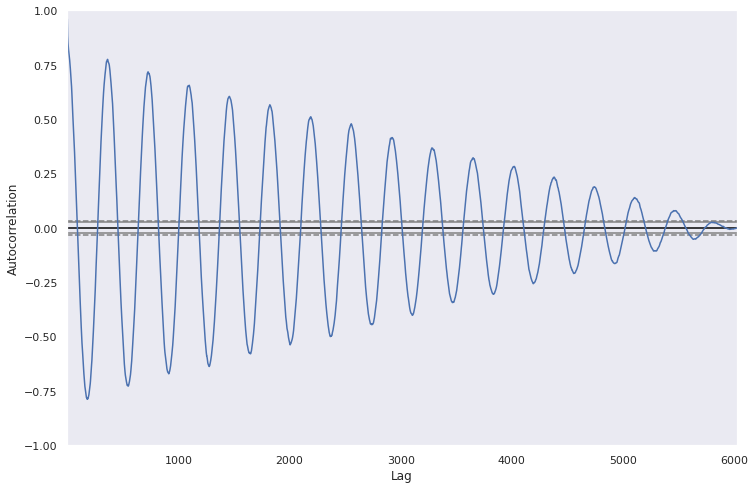

In [ ]:
pd.plotting.autocorrelation_plot(df_PU_SL.Temperatura_Zona_5)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


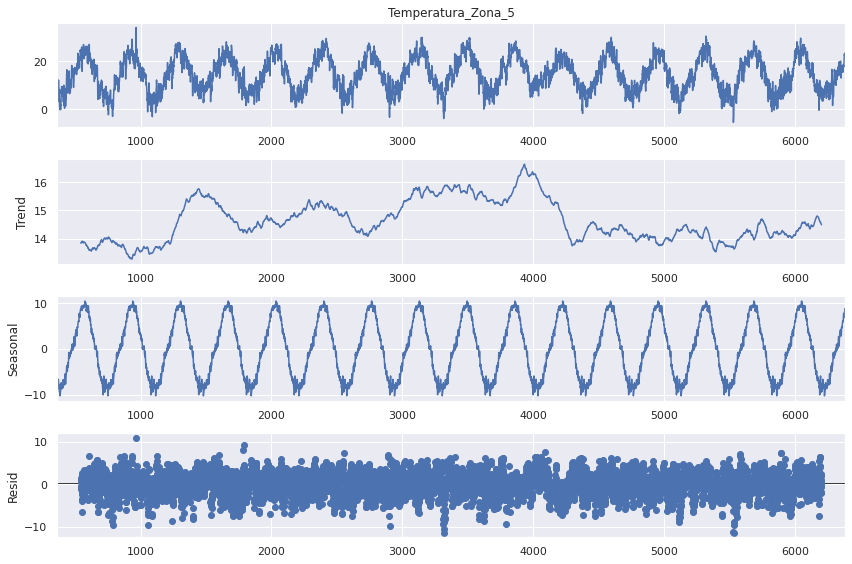

In [ ]:
decompose_result = seasonal_decompose(df_PU_SL.Temperatura_Zona_5, freq=365) 
plt.rcParams['figure.figsize'] = (12, 8) 
fig = decompose_result.plot()

Si scompone l'unica variabile di temperatura in 3 componenti:
- trend-ciclo;
- stagionale;
- irregolare.

Queste vengono successivamente aggiunte al dataset.

In [ ]:
df_PU_SL['Temperatura_Trend'] = decompose_result.trend
df_PU_SL['Temperatura_Season'] = decompose_result.seasonal
df_PU_SL['Temperatura_Resid'] = decompose_result.resid

In [ ]:
df_PU_SL.set_index('Data',inplace = True)
df_PU_SL.sort_index(inplace = True)

Si effettua lo split dei dati in train e test (80-20).

In [ ]:
n = len(df_PU_SL)
f = 0.8
train_PU_SL = df_PU_SL[:int(n*f)]
test_PU_SL = df_PU_SL[int(n*f):]

Il prossimo passo consiste nel normalizzare i dati di train e test per agevolarne la modellazione.

In [ ]:
train_mean = train_PU_SL.mean()
train_std = train_PU_SL.std()
train_normalized = (train_PU_SL - train_mean)/train_std

In [ ]:
test_mean = test_PU_SL.mean()
test_std = test_PU_SL.std()
test_normalized = (test_PU_SL - test_mean)/test_std

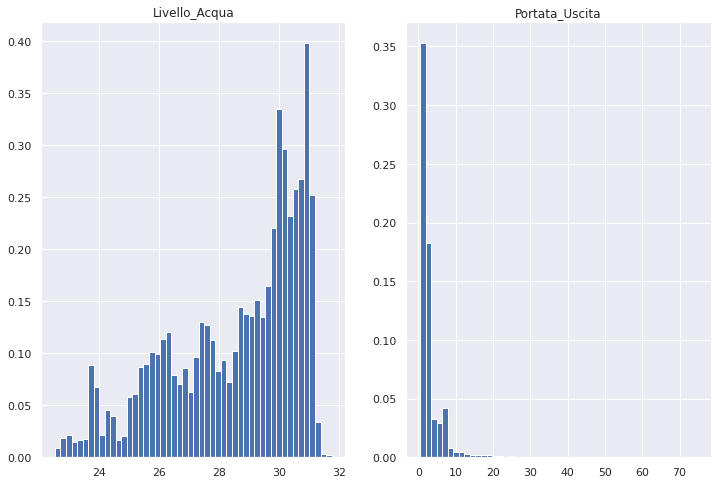

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Livello_Acqua')
ax[0].hist(df_clean.Livello_Acqua, bins = 50, density = True)
ax[1].set_title('Portata_Uscita')
ax[1].hist(df_clean.Portata_Uscita, bins = 50, density = True)
plt.show()

In [ ]:
max_train_LA = max(train_PU_SL.Livello_Acqua)
max_test_LA = max(test_PU_SL.Livello_Acqua)


train_PU_SL.Livello_Acqua =  boxcox(1- train_PU_SL.Livello_Acqua + max_train_LA,0)
test_PU_SL.Livello_Acqua =  boxcox(1- test_PU_SL.Livello_Acqua + max_test_LA,0)
train_PU_SL.Portata_Uscita = 1 + np.log(1 + train_PU_SL.Portata_Uscita)
test_PU_SL.Portata_Uscita = 1 + np.log(1 + test_PU_SL.Portata_Uscita)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


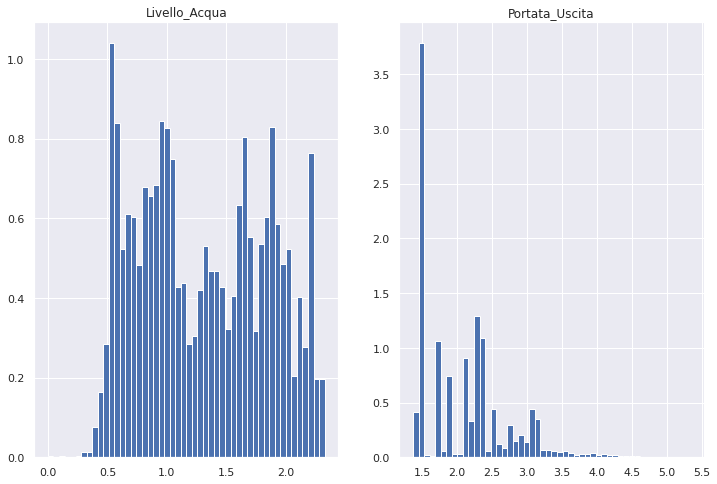

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Livello_Acqua')
ax[0].hist(train_PU_SL.Livello_Acqua, bins = 50, density = True)
ax[1].set_title('Portata_Uscita')
ax[1].hist(train_PU_SL.Portata_Uscita, bins = 50, density = True)
plt.show()

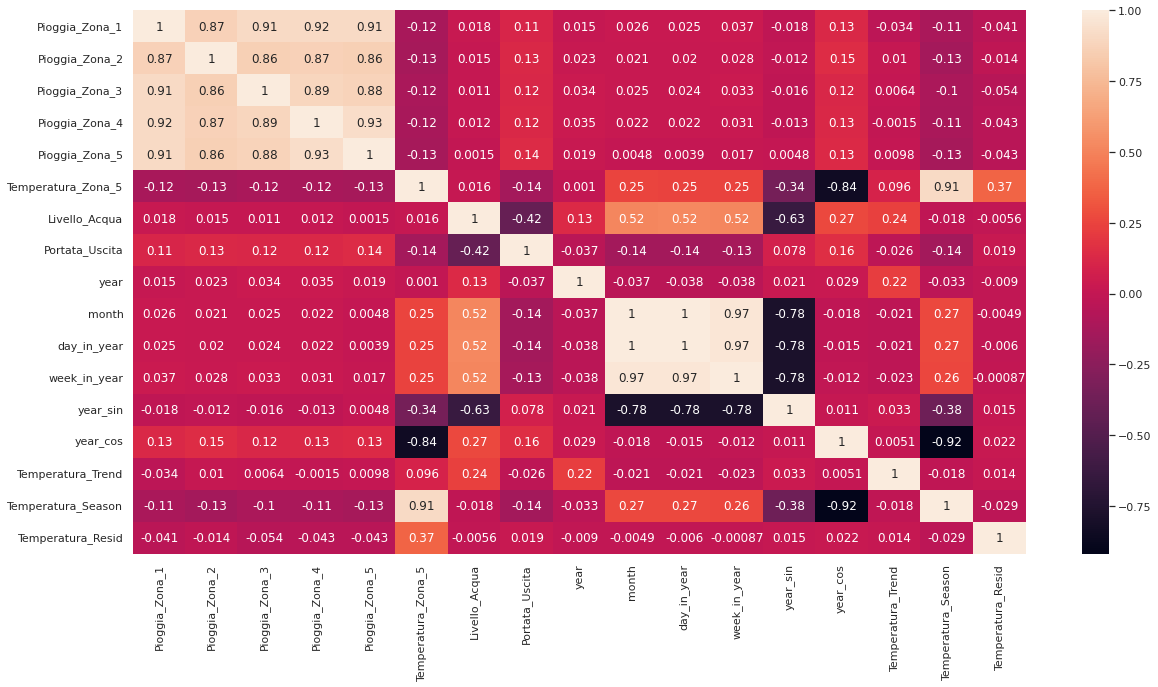

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(train_PU_SL.corr(), annot = True)

Dopo un'attenta analisi, le variabili considerate utili per la predizione finale sono le seguenti:
- Temperatura_trend shift 1;
- Temperatura_Season shift 1;
- Temperatura_Resid shift 1;
- year_sin shift 1;
- year_cos shift 1;
- Portata_Uscita shift 30;
- Livello_Acqua shift 30;
- Livello_Acqua;
- Pioggia Zona 1;
- Pioggia Zona 2;
- Pioggia Zona 3;
- Pioggia Zona 4;
- Pioggia Zona 5;
- Temperatura Zona 5.

In [ ]:
train_shift = train_PU_SL[['Temperatura_Trend','Temperatura_Season','Temperatura_Resid','year_sin','year_cos']].shift(7).add_suffix('_shifted')
test_shift = test_PU_SL[['Temperatura_Trend','Temperatura_Season','Temperatura_Resid','year_sin','year_cos']].shift(7).add_suffix('_shifted')

In [ ]:
#label_shift30_train = train_PU_SL[['Portata_Uscita', 'Livello_Acqua']].shift(30).add_suffix('_shifted')
#label_shift30_test = test_PU_SL[['Portata_Uscita','Livello_Acqua']].shift(30).add_suffix('_shifted')
label_shift30_train = train_PU_SL[['Livello_Acqua']].shift(30).add_suffix('_shifted')
label_shift30_test = test_PU_SL[['Livello_Acqua']].shift(30).add_suffix('_shifted')

In [ ]:
train_PU_SL = pd.concat([train_normalized[features],  train_shift, label_shift30_train, train_PU_SL[['Livello_Acqua', 'Portata_Uscita']]],axis = 1).dropna().iloc[1:]
test_PU_SL = pd.concat([test_normalized[features], test_shift, label_shift30_test, test_PU_SL[['Livello_Acqua', 'Portata_Uscita']]],axis = 1).dropna().iloc[1:]

In [ ]:
train_PU_SL

,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Temperatura_Trend_shifted,Temperatura_Season_shifted,Temperatura_Resid_shifted,year_sin_shifted,year_cos_shifted,Livello_Acqua_shifted,Livello_Acqua,Portata_Uscita
Data,,,,,,,,,,,,,,
2004-07-10,-0.372094,-0.373335,-0.373777,-0.353865,-0.390927,0.783795,13.852329,8.507972,-1.210300,-0.040844,-0.999166,0.559616,0.737164,1.916291
2004-07-11,-0.372094,-0.373335,-0.373777,-0.353865,-0.390927,0.639488,13.857397,8.576747,-0.784144,-0.058026,-0.998315,0.559616,0.751416,1.916291
2004-07-12,-0.372094,-0.373335,-0.373777,-0.353865,-0.390927,0.574551,13.863973,8.485472,-0.399444,-0.075190,-0.997169,0.565314,0.765468,2.098612
2004-07-13,-0.372094,-0.350928,-0.373777,-0.353865,-0.390927,0.170492,13.875342,8.662543,0.462114,-0.092331,-0.995728,0.565314,0.783902,2.098612
2004-07-14,-0.372094,-0.373335,-0.373777,-0.353865,-0.390927,0.949748,13.882329,9.265249,1.502422,-0.109446,-0.993993,0.570980,0.797507,2.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-08,-0.372094,-0.373335,-0.373777,-0.353865,-0.390927,-0.608763,14.509315,-6.267921,0.908606,0.858402,0.512978,1.043804,0.678034,3.079442
2017-03-09,-0.372094,-0.373335,-0.373777,-0.353865,-0.390927,-0.536610,14.505205,-5.434642,0.229437,0.867099,0.498137,0.936093,0.683097,3.079442
2017-03-10,-0.248911,-0.373335,-0.373777,-0.353865,-0.390927,-0.341796,14.490822,-6.314313,3.073491,0.875539,0.483147,0.904218,0.688135,3.079442


Infine si definisce la variabile Target, ossia la portata d'uscita tra 7 giorni.

In [ ]:
train_PU_SL['Target']=train_PU_SL['Portata_Uscita'].shift(-7)
train_PU_SL.drop('Portata_Uscita', axis=1, inplace=True)
train_PU_SL.dropna(axis=0, inplace=True)

test_PU_SL['Target']=test_PU_SL['Portata_Uscita'].shift(-7)
test_PU_SL.drop('Portata_Uscita', axis=1, inplace=True)
test_PU_SL.dropna(axis=0, inplace=True)

In [ ]:
train_PU_SL.to_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/train_PU_SL_T2.csv')
test_PU_SL.to_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/test_PU_SL_T2.csv')